## Assignment 1 - BGN 2331A

*Based on the assignment notebook by Ferenc Huszar, Nic Lane and Neil Lawrence*

##### *Notes:*

* *This notebook takes approximately 11 minutes to fully run on Google Colab. Re-running some computations on Google Colab may lead to crashes due to exceeded RAM use - please try again, possibly with less demanding parameters.*

* *Some computations take a significant amount of time - there will be a comment specifying actions that can be taken if something is taking too long*

* *The principle in this notebook is that code for each question should be runnable independently, and all code used should be clearly laid out there - this of course leads to some duplicated code.*

* *Most questions will have two code cells. The first contains imports, given code, modified given code, and/or reused code. The second one contatins the code answer.*

* *The original explainations by Ferenc Huszar, Nic Lane and Neil Lawrence are included in single text cells for completeness, and the code given there is only executed in cells that answer questions.*

### *Double Descent Background (for reference only)*

In this assignment we are going to start by exploring a recent paper on the 'double descent phenomenon'. 

In [Belkin et al](https://www.pnas.org/content/116/32/15849.short) the authors explore double descent, firstly using *random Fourier features* as a basis function. We quote from their paper below.
> We first consider a popular class of nonlinear parametric models  called random Fourier features (RFF) (13), which can be viewed as a class of 2-layer neural networks with fixed weights in the first layer. The RFF model family $\mathcal{H}_N$ with $N$ (complex-valued) parameters consists of functions
$h : \mathbb{R}^d \rightarrow \mathbb{C}$ of the form
$$
h(x) =\sum_{k=1}^N a_k \phi(x ; v_k ) \quad \text{where} \quad \phi(x ; v_k) := e^{\sqrt{-1}\langle v_k, x\rangle},
$$ 
and the vectors $v_1, \dots , v_N$ are sampled independently from the
standard normal distribution in $\mathbb{R}^d$.

From Belkin et al. pg 2 of paper, section titled **Random Fourier Features**. For more on random Fourier features see [Rahimi and Recht](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf).

**Note** that the notation that Belkin et al use, $\langle v_k, x \rangle$ is just the notation for an inner product between the vector $v_k$ and the vector $x$. We'll use the notation $v_k^\top x$ to denote this below.

Following the papers description, our first task is to create a function for computing the basis. The paper proposes using a basis which is
$$
\exp(i z) = \cos(z) + i \sin(z)
$$
to form the *random Fourier features*. This leads to complex valued weights, $\{a_k\}_{i=1}^N$. So rather than doing that, we set our design matrix up in the following way:
$$
\boldsymbol{\Phi} = \begin{bmatrix} \cos(v_1^\top x_1) & \sin(v_1^\top x_1) & cos(v_2^\top x_1) & \sin(v_2^\top x_1) & \cdots & \cos(v_N^\top x_1) & \sin(v_N^\top x_1) \\
\cos(v_1^\top x_2) & \sin(v_1^\top x_2) & cos(v_2^\top x_2) & \sin(v_2^\top x_2) & \cdots & \cos(v_N^\top x_2) & \sin(v_N^\top x_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\cos(v_1^\top x_n) & \sin(v_1^\top x_n) & cos(v_2^\top x_n) & \sin(v_2^\top x_n) & \cdots & \cos(v_N^\top x_n) & \sin(v_N^\top x_n)\end{bmatrix}
$$
Giving us a matrix $\boldsymbol{\Phi} \in \mathbb{R}^{n \times 2N}$ where we are following Belkin et al's notation with $n$ number of data points and $N$ number of random Fourier features. Note that because each feature (in our representation) contains a sine and a cosine, the total number of basis functions is $2N$. 

The frequencies of the features, as Belkin et al explain, should be sampled from a normal density. In our notation below we collect these features in a matrix `V`, represented here as a two dimensional `numpy` array.  

If the data is stored in a That leads to the following code for implementing the random Fourier features.


```
import numpy as np
```


```
def random_fourier_basis(X, V):
  arg = X@V
  Phi = np.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = np.cos(arg) 
  Phi[:, 1::2] = np.sin(arg)
  return Phi
```
Given our design matrix, $\boldsymbol{\Phi}$ we can compute the output of the functions, which Belkin et al denote $h(x)$ for each of the points using matrix multiplication. 
$$
\mathbf{h} = \boldsymbol{\Phi} \mathbf{a}
$$
where $\mathbf{a} \in \mathbb{R}^N$ is a vector containing the elements $a_k$.

```
def predict(X_test, a, V):
  Phi_test = random_fourier_basis(X_test, V)
  return Phi_test@a
```
> Our learning procedure using $\mathcal{H}_N$ is as follows. Given data $(x_1, y_1), \dots , (x_n , y_n )$ from $\mathbb{R}^{d} \times \mathbb{R}$, we find the predictor $h_{n,N} \in \mathcal{H}_N$ via ERM with squared loss. That is, we minimize the empirical risk objective $\frac{1}{n} \sum_{i=1}^n (h(x_i) − y_i)^2$
over all functions $h \in \mathcal{H}_N$. When the minimizer is not unique (as is always the case when $N > n$), we choose the minimizer whose coefficients $(a_1, \dots , a_N )$ have the minimum $\ell_2$ norm. This choice of norm is intended as an approximation to the RKHS norm $\|h\|_{\mathcal{H}_\infty}$, which is generally difficult to compute for arbitrary functions in $\mathcal{H}_N$ . For problems with multiple outputs (e.g., multiclass classification), we use functions with vector-valued outputs and the sum of the squared losses for each output.

We already reviewed empirical risk minimization in the second lecture of week one. Here, Belkin et al are using the *squared loss* even for a classification task. This is probably not something you'd do in practice, but for our analysis below it will serve as it makes gradients easier to compute, and the optimum easy to solve analytically. 

We can implement the average squared error they described as follows. 
```
def error(X, y, a, V):
  y_pred = predict(X, a, V)
  return np.mean((y_pred - y)**2)
```
And now we can implement the fixed point update equation we reviewed in [Lecture 2 of Week 1](https://mlatcl.github.io/deepnn/lectures/01-02-generalisation-and-neural-networks.html) for fitting the model.
```
def fit(X_train, y_train, N, lambd=0.01):
  d = X_train.shape[1]
  V = np.random.normal(0.0, 1, size=(d, N))
  Phi_train = random_fourier_basis(X_train, V)
  if Phi_train.shape[1]>X_train.shape[0]:
    # N > n, use L2 regularizer
    a = np.linalg.solve(Phi_train.T@Phi_train + lambd*np.eye(N*2), Phi_train.T@y_train)
  else:
    a = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@y_train)
  return a, V
```
Here we have included `lambd` to represent a regularisation parameter, so that we can minimize the $\ell_2$ norm as Belkin et al suggest when the number of parameters in the model (which is $2N$ for this random Fourier basis) is greater than the number of data, $n$. This is called [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization).

### *Loading a Data Set (for reference only)*

For their paper, Belkin et al use the MNIST digits data set. To make things run a little quicker for us, we'll use a digits data set from scikit learn. 
```
import sklearn
from sklearn import datasets

digits = datasets.load_digits()
```
The original data has 10 digits. We'll modify the task form classifyign individual digits to separating curvy digits from those with angles. Our task will be to separate `0`, `3`, `6`, `8`, `9` from `1`, `2`, `4`, `5`, `7`. This leads to an approximate balance between positive and negative examples.
```
X = digits['data']
y = ((digits['target'] == 0)
     | (digits['target'] == 3)
     | (digits['target'] == 6)
     | (digits['target'] == 8)
     | (digits['target'] == 9))
```
We will normalise the input data. Normalization is often a key part of getting machine learning algorithms working well. In many cases, you would normalize the columns of your data independently. But here, because it's an image, my instinct is to apply a single scaling. Because the pixels live naturally on the same scale originally. 
```
X /= X.std()
X /= np.sqrt(64)
```
I've subsequently also scaled by the square root of the dimensionality. This ensures that on average, the length of the vector $x$ is 1/64, or in other words, $1/d$ where $d$ is the dimensionality of the input image (which is $8\times 8$).
Similarly, it's quite common to use labels of $-1$ or $1$ for targets when using a squared error. This works well because it's symmetric about zero. But an encoding of $0$ vs $1$ would also likely work. 
```
y = y*2 - 1
```
We can use scikit learn's built in facility for forming a training and test set from the model. 
```
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=False)
```
And now we can use our code to fit our model. 
```
a, V = fit(X_train, y_train, 200)
```
And check the error. 
```
e = error(X_test, y_test, a, V)
print('Error: {}'.format(e))
```

### **Question 1**

Fit models using different values for $N$ between 1 and 2000. 


Produce a plot that has an $x$-axis given by the number of parameters in the model (remember that's $2N$) divided by the number of *training* data. On the $y$-axis plot the loss computed on the *test* data. This serves as an estimate of the true risk.

Choose appropriate intervals for plotting so that the full form of the curve is seen. Beware that the fit will be slow as $N\rightarrow 2000$ (i.e. uniformly spaced selections may not be the best choice).

You can use `matplotlib` or your preferred plotting library to create the plot.

Describe what you see in the plot with reference to both *classical* generalisation theory and the generalisation performance of modern neural network models.

*6 marks*

In [1]:
## Imports
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## (Mostly) given functions
def random_fourier_basis_numpy(X, V):
  arg = X@V
  Phi = np.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = np.cos(arg) 
  Phi[:, 1::2] = np.sin(arg)
  return Phi

def predict_numpy(X_test, a, V):
  Phi_test = random_fourier_basis_numpy(X_test, V)
  return Phi_test@a

def error_numpy(X, y, a, V):
  y_pred = predict_numpy(X, a, V)
  return np.mean((y_pred - y)**2)
  
def fit_numpy(X_train, y_train, N, lambd=0.01):
  d = X_train.shape[1]
  V = np.random.normal(0.0, 1, size=(d, N))
  Phi_train = random_fourier_basis_numpy(X_train, V)
  if Phi_train.shape[1]>X_train.shape[0]:
    a = np.linalg.solve(Phi_train.T@Phi_train + lambd*np.eye(N*2), Phi_train.T@y_train)
  else:
    a = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@y_train)
  return a, V

def load_digit_data():
  digits = datasets.load_digits()
  X = digits['data']
  y = ((digits['target'] == 0)
      |(digits['target'] == 3)
      |(digits['target'] == 6)
      |(digits['target'] == 8)
      |(digits['target'] == 9))
  X /= X.std()
  X /= np.sqrt(64)
  y = y*2 - 1
  return train_test_split(X, y, test_size=0.5, shuffle=False)

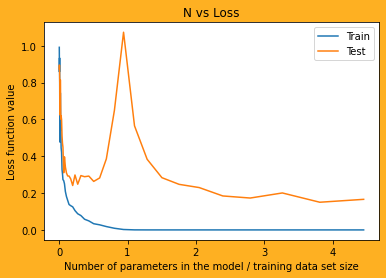

In [2]:
## Code for answer to question 1
def line_plot(x, y1, y2):
  fig = plt.figure()
  ax = plt.axes()
  ax.plot(x, y1, label='Train')
  ax.plot(x, y2, label='Test')
  plt.legend()
  plt.title("N vs Loss")
  plt.xlabel("Number of parameters in the model / training data set size")
  plt.ylabel("Loss function value")
  fig.patch.set_facecolor('#Feb022')

def fit_and_plot_error(digit_data, points):
  X_train, X_test, y_train, y_test = digit_data
  ns = np.unique(np.geomspace(1, 2000, num=points, dtype=int))
  xs = ns*2/len(y_train)
  ys_train = [error_numpy(X_train, y_train, a, V) for (a, V) in [fit_numpy(X_train, y_train, i) for i in ns]]
  ys_test = [error_numpy(X_test, y_test, a, V) for (a, V) in [fit_numpy(X_train, y_train, i) for i in ns]]
  line_plot(xs, ys_train, ys_test)

# Please allow around 30 seconds for this to run, or use a smaller number
fit_and_plot_error(load_digit_data(), 50)

#### Answer 1 text
This chart plots the value of the loss function for different numbers of parameters in the model.

We can see that the training loss function value is behaving very expectedly, with initial values near 1.00, and later convergence near 0.00. 

The testing loss value is much more interesting: At first it gets smaller as the number of parameters increases, but starts growing as it approaches 2N=n. After the peak reached at that critical point, it starts to have lower values again. This is typical behaviour in many neural networks. This is what we call the double descent phenomenon, and the region around the peak is the critical regime. 

According to the classical generalisation theory, the testing error value is the common bias-variance trade-off, and using larger models yields worse results. In particular, using a small N leads to models with low variance (simple models return simple results), but high bias, as the model is not able to describe the data it is given. Using a more complex model by setting a larger N leads to less bias as the model is able to describe the system better, but higher variance since there are more variables in the model. This is the behaviour we see in the first part of the graph (from 0 to 2N/n = 1). The location of this peak is not accidental, and a rule-of-thumb explanation would be that an equation with k variables can always perfectly fit k given values, resulting in zero error, but a useless prediction function.

However in the modern neural theories, we expect models to perform better with higher model sizes. This is the behaviour we see in the second portion of the graph (from 2n/n = 1 onwards). This is due to the Tikhonov regularisation present in the model - it is forced to find small weights, reducing variance.

Combining the theories from classical and modern approaches leads to a unified theory of double descent, which is very well visible in the chart above.

### *Gradient descent in pytorch (for reference only)*


Having seen the model above written in `numpy` we are now going to explore the same model in `pytorch`. First we rewrite our basis functions.
```
import torch
```
```
def random_fourier_basis(X, V):
  arg = X@V
  Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = torch.cos(arg) 
  Phi[:, 1::2] = torch.sin(arg)
  return Phi
```
```
def predict(X_test, a, V):
  Phi_test = random_fourier_basis(X_test, V)
  return Phi_test@a
```
```
def error(X, y, a, V):
  y_pred = predict(X, a, V)
  return torch.mean((y_pred - y)**2)
```
```
# For completeness we also include the function for 'direct fit' in pytorch. You 
# don't need it for the answers below but you can use it to check convergence
# if you like.

def fit(X_train, y_train, N, lambd=0.01):
  d = X_train.shape[1]
  V = torch.normal(0.0, 1, size=(d, N))
  Phi_train = fourier_basis(X_train, V)
  if Phi_train.shape[1]>X_train.shape[0]:
    # N > n, use L2 regularizer
    a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train + lambd*eye(N*2))
  else:
    a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train)
  return a, V
```
Because we will fit these models with gradient descent now, we have to randomly initialize the parameters.
```
a = torch.normal(0, 0.001, size=(2*N, 1))
V = torch.normal(0.0, 1, size=(X.shape[1], N))
```
We also have to tell `torch` that `a` is a variable that we would like to later calculate gradients with respect to, using the `.requires_grad` attribute. The result of this is that wherever we use the variable `a` in subsequent Maths operations, a computational graph with all those operations is going to be built in the background. This computational graph is what allows the `autograd` module of `torch` to later calculate gradients using reverse-mode automatic differentiation, a.k.a. backpropagation.

As in this example we assume `V` to be fixed to randomly selected values, and not learned, so we don't need to do the same for that variable.
```
a.requires_grad=True
```
*We* need to convert our training and test data from `numpy` arrays into `pytorch` tensors. Note that by default pytoch works with single precision, so we also convert these data arrays (which are `double` in `numpy`) to `float`.
```
Xt_train = torch.from_numpy(X_train).float()
Xt_test = torch.from_numpy(X_test).float()
yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()
```
The magic of automatic differentiation allows us to compute the gradients in `pytorch` by requesting `.backward()`. This function can be called on any `pytorch` tensor that has a computational graph attached. Backpropagation will walk backwards on this computational graph and save the relevant gradients in the `.grad` attribute of each `Tensor` whose `requires_grad` attribute is set to `True.`

```
error(Xt_train, yt_train, a, V).backward()
```
And now we can simply look at the gradient from pytorch.
```
a.grad
```

### **Question 2**

Analytically derive the gradient for the objective function with respect to parameters $\mathbf{a}$. Give your answer in the box below.

Then implement the answer in code and compare the gradient to the values given by `autograd` in `pytorch` with a scatter plot.

*4 marks*

#### Answer 2

Please add your answer by completing the equation below.

The gradient of the loss with respect to $\mathbf{a}$ is:
$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = \frac{2}{n} \boldsymbol{\Phi}^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})
$$

Derivation:
$$\eqalign{\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) &= \frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\mathbf{a}^\top \boldsymbol{\Phi}^\top -\mathbf{y}^\top)(\boldsymbol{\Phi}\mathbf{a} - \mathbf{y})
\cr&= \frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\mathbf{a}^\top \boldsymbol{\Phi}^\top \boldsymbol{\Phi} \mathbf{a} - \mathbf{y}^\top \boldsymbol{\Phi}\mathbf{a} - \mathbf{a}^\top \boldsymbol{\Phi}^\top \mathbf{y} + \mathbf{y}^\top\mathbf{y})
\cr&= \frac{\text{d}}{\text{d} \mathbf{a}} (\frac{1}{n} \mathbf{a}^\top \boldsymbol{\Phi}^\top \boldsymbol{\Phi} \mathbf{a}) - \frac{1}{n} \boldsymbol{\Phi}^\top \mathbf{y} - \frac{1}{n} \boldsymbol{\Phi}^\top \mathbf{y} + 0
\cr&= \frac{1}{n} (\frac{\text{d}}{\text{d} \mathbf{a}} \mathbf{a}^\top \boldsymbol{\Phi}^\top \boldsymbol{\Phi} \mathbf{a}) - \frac{2}{n} \boldsymbol{\Phi}^\top \mathbf{y}
\cr&= \frac{1}{n} (\boldsymbol{\Phi}^\top \boldsymbol{\Phi} 2\mathbf{a}) - \frac{2}{n} \boldsymbol{\Phi}^\top \mathbf{y} =
\cr&= \frac{2}{n} (\boldsymbol{\Phi}^\top \boldsymbol{\Phi} \mathbf{a}) - \frac{2}{n} \boldsymbol{\Phi}^\top \mathbf{y}
\cr&= \frac{2}{n} \boldsymbol{\Phi}^\top (\boldsymbol{\Phi} \mathbf{a} - \mathbf{y})}$$

In [3]:
## Imports
import torch
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## (Mostly) given functions
def random_fourier_basis_torch(X, V):
  arg = X@V
  Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = torch.cos(arg) 
  Phi[:, 1::2] = torch.sin(arg)
  return Phi

def predict_torch(X_test, a, V):
  Phi_test = random_fourier_basis_torch(X_test, V)
  return Phi_test@a

def error_torch(X, y, a, V):
  y_pred = predict_torch(X, a, V)
  return torch.mean((y_pred - y)**2)

def torchify(digit_data):
  X_train, X_test, y_train, y_test = digit_data
  Xt_train = torch.from_numpy(X_train).float()
  Xt_test = torch.from_numpy(X_test).float()
  yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
  yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()
  return Xt_train, Xt_test, yt_train, yt_test

def load_digit_data():
  digits = datasets.load_digits()
  X = digits['data']
  y = ((digits['target'] == 0)
      |(digits['target'] == 3)
      |(digits['target'] == 6)
      |(digits['target'] == 8)
      |(digits['target'] == 9))
  X /= X.std()
  X /= np.sqrt(64)
  y = y*2 - 1
  return train_test_split(X, y, test_size=0.5, shuffle=False)

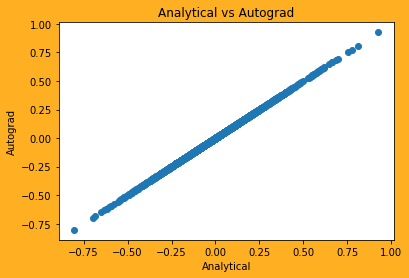

In [4]:
## Code for answer to question 2
def analytical_values(n, Phi, a, y):
  return (2/n) * np.matmul(np.transpose(Phi), (np.matmul(Phi, a) - y))

def autograd_values(n, V, a, y):
  a.requires_grad=True
  error_torch(Xt_train, yt_train, a, V).backward()
  return a.grad

def scatter_plot(x, y):
  fig = plt.figure()
  ax = plt.axes()
  ax.scatter(x, y)
  plt.title("Analytical vs Autograd")
  plt.xlabel("Analytical")
  plt.ylabel("Autograd")
  fig.patch.set_facecolor('#Feb022')

## Calculating loss gradient with respect to a
# Some variables here are duplicates, included this way to be consistent with the equation above
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
y = yt_train
n = len(yt_train)
a = torch.normal(0, 0.001, size=(2*n, 1))
V = torch.normal(0.0, 1, size=(Xt_train.shape[1], n))
Phi = random_fourier_basis_torch(Xt_train, V)
  
analytical = analytical_values(n, Phi, a, y)
autograd = autograd_values(n, V, a, y)

scatter_plot(analytical, autograd)

The scatter plot is a straight line because all the values are equal, signifying that autograd works equally well as analytical differentiation.

### *A simple SGD training loop (for reference only)*

Optimisaton of neural networks is typically done by some variant of gradient descent. `pytorch` provides some convenient omptimizaton routines, like `torch.optim.SGD` that we can use to fit the stochastic gradient descent algorithm. 

We include an example of a simple stochastic gradient descent training loop below.
```
from torch.utils.data import TensorDataset, DataLoader

def sgd_fit(
    X_train, y_train,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=90):
  ''' Fits a generalised linear model with N random fourier features
  to data using stochastic gradient descent.

  Parameters
  ----------
  X_train, y_train : torch.Tensor
    Training input and output tensors
  N : int
    Number of random Fourier features to use
  a_std : float
    Standard deviation of parameters a at initialization
  lr : float
    Learning rate
  epochs : int
    Number of training epochs
  batchsize : int
    Number of datapoints in each minibatch

  Returns
  -------
  a, V
    torch.Tensors contatining parameters of the trained model
  '''
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  a = torch.normal(0, a_std, size=(2*N, 1))
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=lr)
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()
  return a, V
  ```
Note: In practice, one would not write a training loop from scratch like this. There are well-tested libraries with extensive functionality like `ignite` in pytorch and `keras` in TensorFlow. We included this simple code so as to illustrate what is going on in a SGD training loop.

### **Question 3**

Now we have used `pytorch` to compute the gradients, we'll optimize with stochastic gradient descent. 

Firstly, you'll look at the convergence of stochastic gradient descent for four different sizes of model, $N=5$, $N=100$, $N=400$ and $N=1000$.

Modify the `sgd_fit` code to monitor convergence of both the test error and the training error as training progresses.

Produce plots of the changing training and test error as the iterations procede for each model size $N$ above.

For each model size ($N$) vary the the learning rate, number of iterations, batchsize, to improve the rate of convergence.

You may want to use `torch.manual_seed` to set the random seed. Try different random seeds. What do you find?

*6 marks*



In [5]:
## Imports
import torch
import numpy as np
import math
import statistics
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## (Mostly) given and reused functions
def sgd_fit_plot(X_train, y_train, X_test, y_test, N, a_std = 0.001, lr=0.001, epochs=100, batchsize=30):
  torch.random.manual_seed(0)
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  a = torch.normal(0, a_std, size=(2*N, 1))
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X_train.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=lr)
  train_error = []
  test_error = []
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error_torch(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()
    train_error.append(error_torch(X_train, y_train, a, V))
    test_error.append(error_torch(X_test, y_test, a, V))
  return a, V, train_error, test_error

def load_digit_data():
  digits = datasets.load_digits()
  X = digits['data']
  y = ((digits['target'] == 0)
      |(digits['target'] == 3)
      |(digits['target'] == 6)
      |(digits['target'] == 8)
      |(digits['target'] == 9))
  X /= X.std()
  X /= np.sqrt(64)
  y = y*2 - 1
  return train_test_split(X, y, test_size=0.5, shuffle=False)

def random_fourier_basis_torch(X, V):
  arg = X@V
  Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = torch.cos(arg) 
  Phi[:, 1::2] = torch.sin(arg)
  return Phi

def predict_torch(X_test, a, V):
  Phi_test = random_fourier_basis_torch(X_test, V)
  return Phi_test@a

def error_torch(X, y, a, V):
  y_pred = predict_torch(X, a, V)
  return torch.mean((y_pred - y)**2)

def torchify(digit_data):
  X_train, X_test, y_train, y_test = digit_data
  Xt_train = torch.from_numpy(X_train).float()
  Xt_test = torch.from_numpy(X_test).float()
  yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
  yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()
  return Xt_train, Xt_test, yt_train, yt_test

In [6]:
## Code for answer to question 3
def error_plot(x, train, test, title="Error value", n=0):
  fig = plt.figure()
  ax = plt.axes()
  ax.plot(x, train, label="Train")
  ax.plot(x, test, label="Test")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel(title)
  if n!=0:
    plt.title("N="+str(N))
  fig.patch.set_facecolor('#Feb022')

def rate_of_convergence(array):
  return np.array([abs(array[k] - array[k+1])/abs(array[k+1] - array[k+2]) for k in range(len(array[:-2]))], dtype='float')

def time_to_converge(array, percent):
  return np.where(np.array([(element - min(array))/(1-min(array)) for element in array], dtype='float')<percent)[0][0]

def plot_multiple_lr(N, ns=[]):
  Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
  fig, axes = plt.subplots(1, len(ns), figsize=(15,3))
  for i in range(len(ns)):
    a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=ns[i])
    train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
    axes[i].plot(np.arange(len(train_error_numpy)), train_error_numpy, label="Train")
    axes[i].plot(np.arange(len(test_error_numpy)), test_error_numpy, label="Test")
    axes[i].set_title("lr: "+str(ns[i]))
  plt.tight_layout()
  fig.patch.set_facecolor('#Feb022')

def plot_multiple_epochs(N, ns=[]):
  Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
  fig, axes = plt.subplots(1, len(ns), figsize=(15,3))
  for i in range(len(ns)):
    a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, epochs=ns[i])
    train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
    axes[i].plot(np.arange(len(train_error_numpy)), train_error_numpy, label="Train")
    axes[i].plot(np.arange(len(test_error_numpy)), test_error_numpy, label="Test")
    axes[i].set_title("epochs: "+str(ns[i]))
  plt.tight_layout()
  fig.patch.set_facecolor('#Feb022')

def plot_multiple_batchsize(N, ns=[]):
  Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
  fig, axes = plt.subplots(1, len(ns), figsize=(15,3))
  for i in range(len(ns)):
    a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, batchsize=ns[i])
    train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
    axes[i].plot(np.arange(len(train_error_numpy)), train_error_numpy, label="Train")
    axes[i].plot(np.arange(len(test_error_numpy)), test_error_numpy, label="Test")
    axes[i].set_title("batchsize: "+str(ns[i]))
  plt.tight_layout()
  fig.patch.set_facecolor('#Feb022')

##### N=5

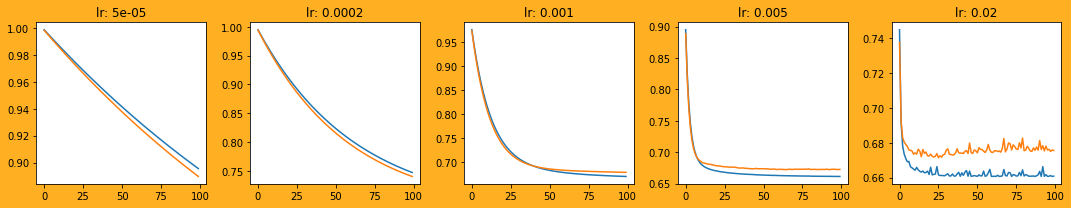

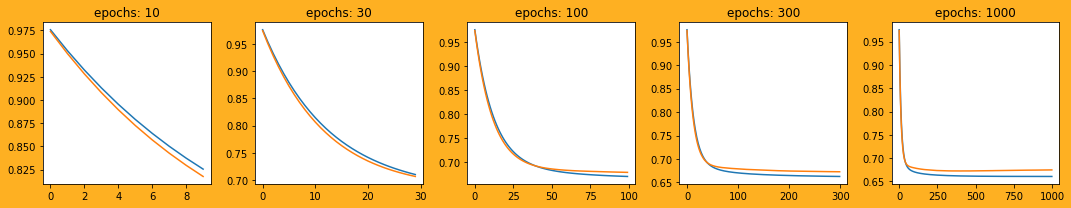

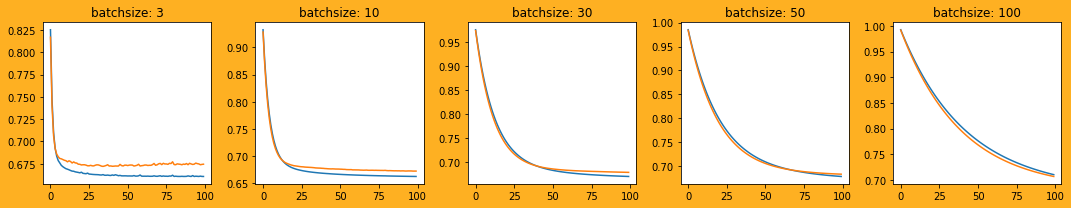

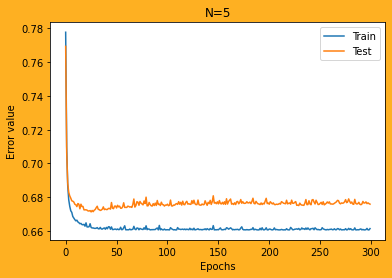

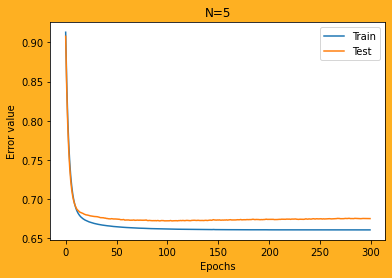

In [7]:
## Code for answer to question 3 for N=5
# Please allow around 1 minute for this to run, or use fewer potential values
N = 5
plot_multiple_lr(N, ns=[0.00005, 0.0002, 0.001, 0.005, 0.02])
plot_multiple_epochs(N, ns=[10, 30, 100, 300, 1000])
plot_multiple_batchsize(N, ns=[3, 10, 30, 50, 100])

# Optimal parameters: lr=0.005, epochs=300, batchsize=10
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=0.005, epochs=300, batchsize=10)
train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
error_plot(np.arange(len(train_error)), train_error_numpy, [x.detach().numpy() for x in test_error], n=N)

# Manually adjusted parameters: lr=0.002, epochs=300, batchsize=15
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=0.002, epochs=300, batchsize=15)
train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
error_plot(np.arange(len(train_error)), train_error_numpy, [x.detach().numpy() for x in test_error], n=N)

##### N=100

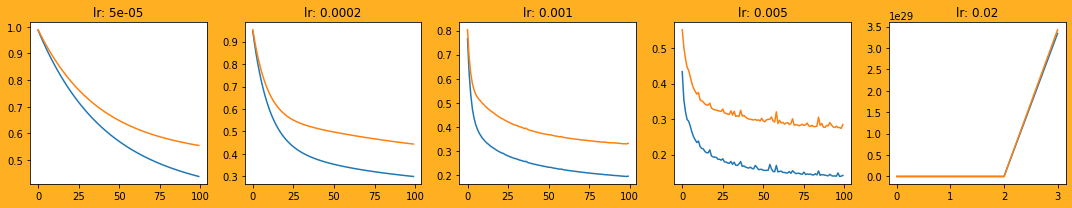

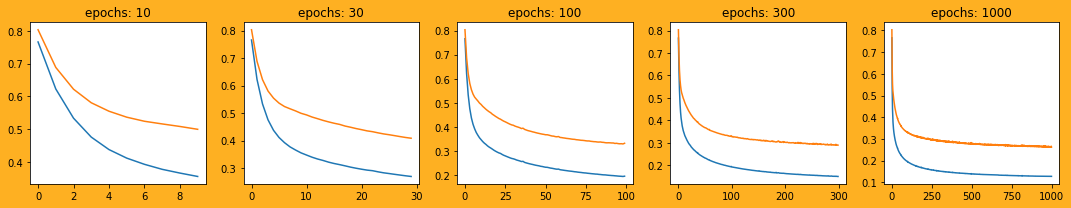

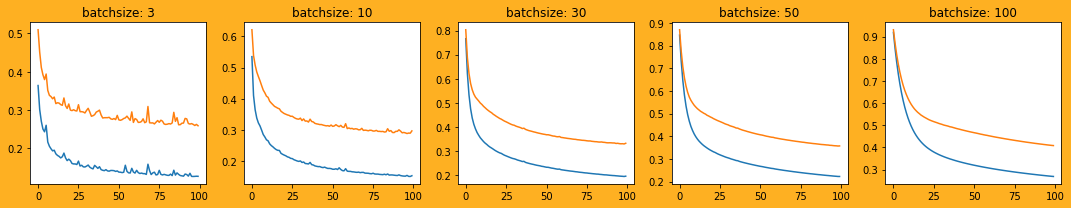

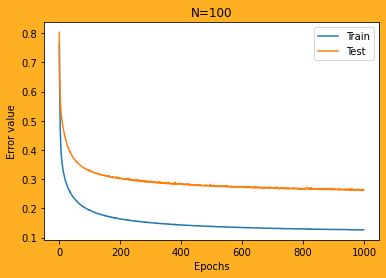

In [8]:
## Code for answer to question 3 for N=100
# Please allow around 2 minutes for this to run, or use fewer potential values
N = 100
plot_multiple_lr(N, ns=[0.00005, 0.0002, 0.001, 0.005, 0.02])
plot_multiple_epochs(N, ns=[10, 30, 100, 300, 1000])
plot_multiple_batchsize(N, ns=[3, 10, 30, 50, 100])

# Optimal parameters: lr=0.001, epochs=1000, batchsize=30
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=0.001, epochs=1000, batchsize=30)
train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
error_plot(np.arange(len(train_error)), train_error_numpy, [x.detach().numpy() for x in test_error], n=N)

##### N=400

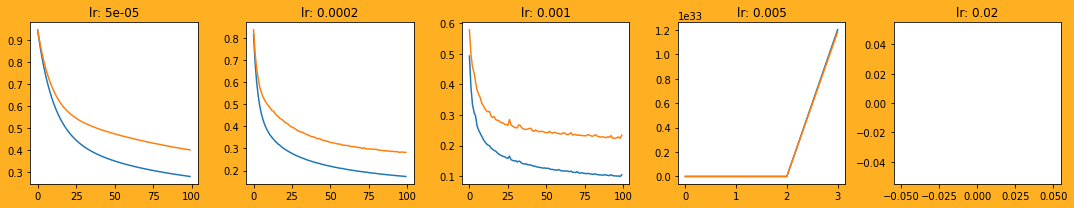

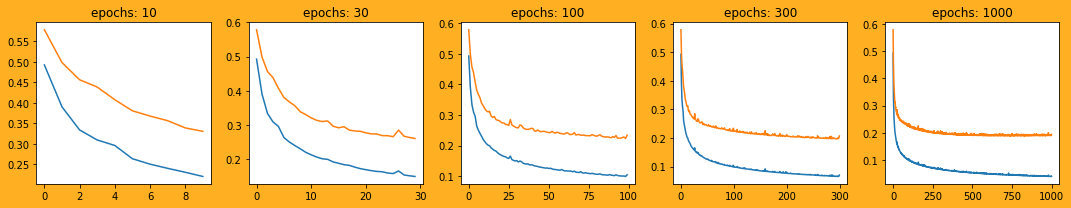

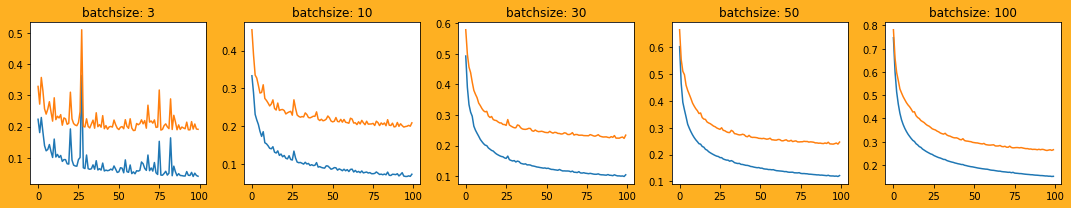

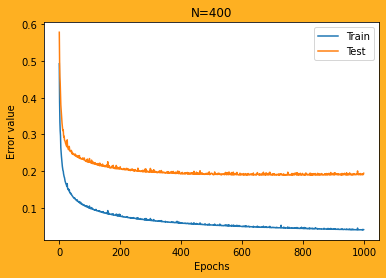

In [9]:
## Code for answer to question 3 for N=400
# Please allow around 3 minutes for this to run, or use fewer potential values
N = 400
plot_multiple_lr(N, ns=[0.00005, 0.0002, 0.001, 0.005, 0.02])
plot_multiple_epochs(N, ns=[10, 30, 100, 300, 1000])
plot_multiple_batchsize(N, ns=[3, 10, 30, 50, 100])

# Optimal parameters: lr=0.0002, epochs=1000, batchsize=50
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=0.001, epochs=1000, batchsize=30)
train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
error_plot(np.arange(len(train_error)), train_error_numpy, [x.detach().numpy() for x in test_error], n=N)

##### N=1000

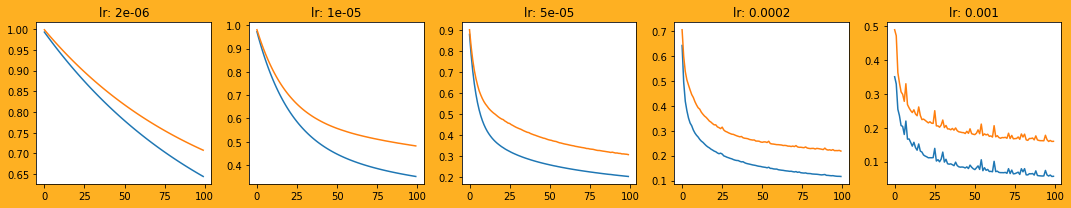

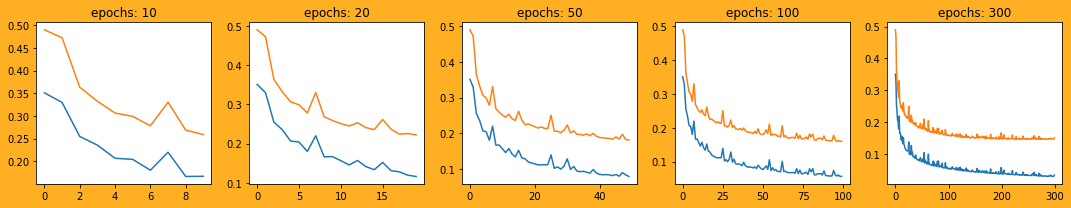

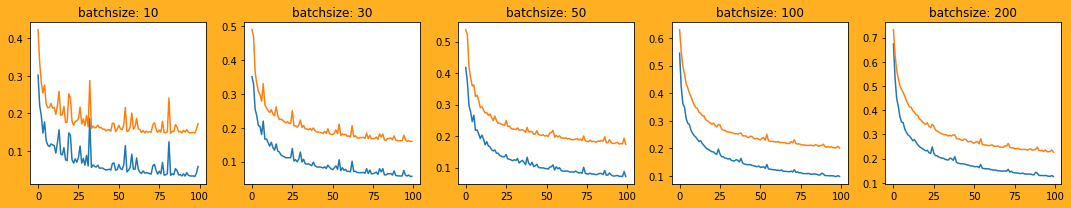

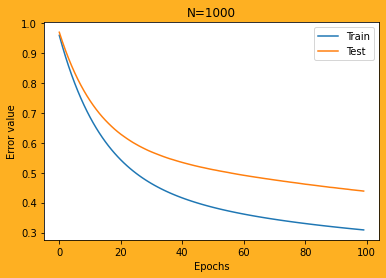

In [10]:
## Code for answer to question 3 for N=1000
# Please allow around 2 minutes for this to run, or use fewer potential values.
# The notebook may crash if some values are changed, or repreatedly re-run.
N = 1000
plot_multiple_lr(N, ns=[0.000002, 0.00001, 0.00005, 0.0002, 0.001])
plot_multiple_epochs(N, ns=[10, 20, 50, 100, 300])
plot_multiple_batchsize(N, ns=[10, 30, 50, 100, 200])

# Optimal parameters: lr=0.0002, epochs=1000+, batchsize=100
Xt_train, Xt_test, yt_train, yt_test = torchify(load_digit_data())
a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=0.00005, epochs=100, batchsize=100)
train_error_numpy, test_error_numpy = [x.detach().numpy() for x in train_error], [x.detach().numpy() for x in test_error]
error_plot(np.arange(len(train_error)), train_error_numpy, [x.detach().numpy() for x in test_error], n=N)

#### Answer 3

The first row of each of the plots represents the models with changed learning rates only. With a lower learning rate the minimum simply wasn't being reached fast enough, and with a learning rate that was too high, the negative effects of variance overshadowed any potential improvements.

The second row of each of the plots represents the models with differing epoch counts. Too few epochs usually results in insufficient convergence, while too many results in wasted computing power, and sometimes overfitting.

The third row of each of the plots represents the models with differing batchsizes. The trade-off in this case is opposite to the learning rate case - a smaller batchsize introduces faster convergence but more variance, whereas larger batchsizes converge longer, but are much more stable.

The final (*usually*) chart represents the model which employs these values. It usually reaches the lowest test error and has other good properties like low variance and fast convergence. However, sometimes that is not the case, as combining the best individual features and expecting the best combined product leads to the tragedy of the Camel: *the horse designed by a committee*. When that is the case, an additional manually adjusted model is given, with better parameters and behaviour (often learning rate and batchsize changes are moderated to fit together better) - more on this later.

1.   N=5. The individually best fitting parameters for this case were learning rate 0.005, 300 epochs, and batchsize 10. This however was not optimal together, so I settled on the parameters: lr=0.002, epochs=300, batchsize=15. The final test error value reached was around 0.7.

2.   N=100. The individually best fitting parameters for this case were learning rate 0.001, 1000 epochs, and batchsize 30. These parameters worked together well and were not readjusted. The final test error value reached was around 0.3.

3.   N=400. The individually best fitting parameters for this case were learning rate 0.0002, 1000 epochs, and batchsize 50. These parameters worked together well and were not readjusted. Some interesting pathological results were visible with learning rates over 0.005. The final test error value reached was around 0.2.

4.   N=1000 *due to the limitations of Google Colab (RAM crash) I was unable to see it's behaviour for many parameters, especially high epoch counts*. It is clear from previous results that at least 1000 epochs will be optimal, however numbers of that magnitude crashed Google Colab, so unfortunately that remains an assumption. For the optimal learning rate and batchsize, they were 0.00005 and 100 respectively. The final test error value reached was around 0.3, but that is not a representative value, as the model was not allowed to fully converge due to the aforementioned limitations. It would surely have a lower error value if run for more epochs.

Although larger models reach their ultimate error values slower, those values are much lower, signalling a better model. If those models were only trying to reach error values equal to the N=5 case, they could easily do that in just 1 or 2 steps.

*   With higher model dimensionalities, we are getting much lower errors, but also the error values are much more variable, and the lines on the graph much less smooth, causing problems when defining convergence.

*   Optimising for quick convergence is not the same as optimising for best performance, or lowest error. The quickest per-epoch-convergence happens when the variance is highest (high learning rates, low batchsizes), but those results are overshadowed by the variance they cause, and cannot be considered good for long-term convergence.

This investigation could be extended to produce a three dimensional matrix of charts, for every possible combination of parameter values, but due to the limitations of Google Colab it was not feasible to produce $N^3$ charts. Another way of going about this would be to set parameters in order (ie. choose lr first, then choose epochs given the new lr, then choose batchsize given lr and epochs), possibly doing multiple passes until no new improvements along any axis are found, settling on a (local) minimum. I did perform a version of that when manually fixing "camels", however automatising this process would be equivalent to *meta* machine learning, and the important aspect of the code is to showcase how varying these parameters effects the convergence rate and error values of the network.

### **Question 4**

Use what you have learned about learning rates and number of training iterations to recreate the plot of test error against $2N/n$  but using stochastic gradient descent to plot the new model. 

Justify your choice of learning rate and model dimensionality.

Compare this plot with the direct fit you did in numpy above. How do they differ?

*8 marks*

In [11]:
## Imports
import torch
from torch.utils.data import TensorDataset, DataLoader
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import math

## (Mostly) given or reused code
def sgd_fit_plot(X_train, y_train, X_test, y_test, N, a_std = 0.001, lr=0.001, epochs=100, batchsize=30):
  torch.random.manual_seed(0)
  dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
  )
  a = torch.normal(0, a_std, size=(2*N, 1))
  a.requires_grad=True
  V = torch.normal(0.0, 1, size=(X_train.shape[1], N))
  optimizer = torch.optim.SGD([a], lr=0.001)
  train_error = []
  test_error = []
  for t in range(epochs):
    for X_minibatch, y_minibatch in dataloader:
	    optimizer.zero_grad()
	    error_torch(X_minibatch, y_minibatch, a, V).backward()
	    optimizer.step()
    train_error.append(error_torch(X_train, y_train, a, V))
    test_error.append(error_torch(X_test, y_test, a, V))
  return a, V, train_error, test_error

def random_fourier_basis_torch(X, V):
  arg = X@V
  Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
  Phi[:, 0::2] = torch.cos(arg) 
  Phi[:, 1::2] = torch.sin(arg)
  return Phi

def predict_torch(X_test, a, V):
  Phi_test = random_fourier_basis_torch(X_test, V)
  return Phi_test@a

def error_torch(X, y, a, V):
  y_pred = predict_torch(X, a, V)
  return torch.mean((y_pred - y)**2)

def torchify(digit_data):
  X_train, X_test, y_train, y_test = digit_data
  Xt_train = torch.from_numpy(X_train).float()
  Xt_test = torch.from_numpy(X_test).float()
  yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
  yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()
  return Xt_train, Xt_test, yt_train, yt_test

def load_digit_data():
  digits = datasets.load_digits()
  X = digits['data']
  y = ((digits['target'] == 0)
      |(digits['target'] == 3)
      |(digits['target'] == 6)
      |(digits['target'] == 8)
      |(digits['target'] == 9))
  X /= X.std()
  X /= np.sqrt(64)
  y = y*2 - 1
  return train_test_split(X, y, test_size=0.5, shuffle=False)

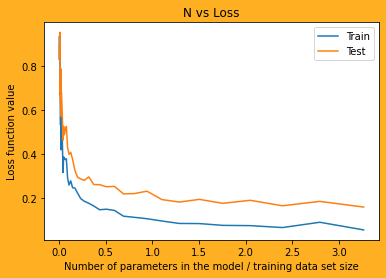

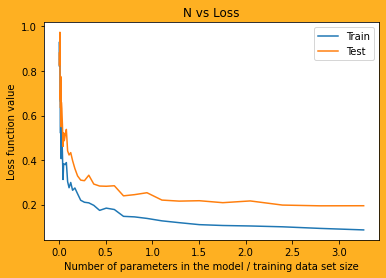

In [12]:
## Code for answer to question 4
def line_plot_2(x, y1, y2):
  fig = plt.figure()
  ax = plt.axes()
  ax.plot(x, y1, label="Train")
  ax.plot(x, y2, label="Test")
  plt.legend()
  plt.title("N vs Loss")
  plt.xlabel("Number of parameters in the model / training data set size")
  plt.ylabel("Loss function value")
  fig.patch.set_facecolor('#Feb022')

def get_error(digit_data, N):
  Xt_train, Xt_test, yt_train, yt_test = digit_data
  a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, a_std = 0.01, lr=0.0005, epochs=100, batchsize=40)
  return train_error[-1].detach().numpy(), test_error[-1].detach().numpy()

def fit_and_plot_error(digit_data, n):
  Xt_train, Xt_test, yt_train, yt_test = digit_data
  ns = np.unique(np.geomspace(1, 1000, num=n, dtype=int))
  xs = ns*2/len(yt_train)
  es = [get_error(digit_data, N) for N in ns]
  (ys_train, ys_test) = zip(*es)
  line_plot_2(xs, ys_train, ys_test)

def get_error2(digit_data, N):
  Xt_train, Xt_test, yt_train, yt_test = digit_data
  a, V, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, a_std = 0.01, lr=0.02/(N**0.87), epochs=100, batchsize=max(int(16.04*math.log(N)-10.82),1))
  return train_error[-1].detach().numpy(), test_error[-1].detach().numpy()

def fit_and_plot_error(err, digit_data, n):
  Xt_train, Xt_test, yt_train, yt_test = digit_data
  ns = np.unique(np.geomspace(1, 2000, num=n, dtype=int))
  xs = ns*2/len(yt_train)
  es = [err(digit_data, N) for N in ns]
  (ys_train, ys_test) = zip(*es)
  line_plot_2(xs, ys_train, ys_test)

# Please allow around 2 minutes for this to run, or use a smaller number
fit_and_plot_error(get_error, torchify(load_digit_data()), 50)

# Please allow around 4 minutes for this to run, or use a smaller number
fit_and_plot_error(get_error2, torchify(load_digit_data()), 50)

#### Answer 4

This chart plots the value of the loss function for different numbers of parameters in the model, same as the chart in part 1.

We can see that the training loss function value is behaving very expectedly, with initial values near 1.00, and later convergence close to zero. The testing loss function value is higher then the training function value - it converges below 0.2.

Choosing the parameters was based on the information learned in Question 3. We know that the optimal learning rate varied from 0.005 to 0.00005, the necessary number of iterations was sometimes above 1000, and the batchsize varied from 15 to 100. 

In order to be fair the values chosen for the first pass are ones that fit in the (logarithmic) middle of that range - learning rate 0.0005, batchsize 40. The number of epochs was chosen to be 1000. 

The second chart directly implements what we have learned in Question 3 - different model sizes have different optimal parameters. Here they were approximated by simple equations: lr = 0.02/N^0.87, batchsize = 16.04*ln(N)-10.82 (minimum of 1). These do not perfectly align with all values reached in Question 3, but are quite close overall and match perfectly for N=5 and N=1000.

Comparing the charts usually shows that the one with dynamically chosen learning rate and batchsize performs slightly better and has lower variance, as shown/discussed in question 3. The differences become even more apparent for higher numbers of epochs, but running that in Google Colab is not recommended, as it will take ~10 minutes for 300 epochs, and likely crash for 1000 epochs.

The different parameters being optimal depending on the circumstances highlights the importance of considering an adaptive learning rate for SGD models.

Multiple re-runs of the SGD may show that the function arrives at different conclusions about the optimal fit - this is a flaw of models that involve randomised behaviour, as they may arrive at a different local minima depending on the random seed.

##### Comparing with Question 1:

We no longer see the double descent phenomenon. This is an interesting property of SGD models, that is explained by the fact that SGD introduces randomness (as the name suggests) into the training procedure, not allowing the algorithm to fall into the pitfalls of overfitting, acting as an implicit regulariser.

The overall results of SGD are better - it has a lower final error, much faster convergence, and doesn't suffer from the negative effects of the double descent phenomenon. It does however have a significantly longer runtime.

### *Sawtooth network (for reference only)*

This part of the assignment looks at the *sawtooth* network Ferenc showed in the third lecture to demonstrate that deep ReLU networks can represent exponentially complex piecewise linear functions. The function is defined by the following recursion:

\begin{align}
f_l(x) &= 2\cdot \vert f_{l-1}(x)\vert - 2\\
f_0(x) &= x
\end{align}

This function can be implemented as a deep, narrow neural network with just two ReLU units at each layer. Below, I provide a simple `pytorch` implementation. The network has three different layers in it: the input layer, the middle layers, which are repeated, and the output layer. ReLU nonlinearities are sandwiched between them.

```
from torch.nn import Identity, Sequential, Linear, ReLU

def sawtooth_input_layer():
  '''Input layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(1, 2, bias=False)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[1], [-1]])
  return layer 

def sawtooth_middle_layer():
  '''Middle layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer

def sawtooth_output_layer():
  '''Output layer of a Sawtooth network. A Linear layer with fixed weights.'''
  layer = Linear(2, 1)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2]])
    layer.bias.data = torch.Tensor([-2])

  return layer

def get_sawtooth_network(num_hidden_layers = 5, middle_layer = sawtooth_middle_layer):
  '''Returns a nn.Sequential model with ReLU activations and weights fixed to
  implement the sawtooth function.
  
  Parameters
  ----------
  num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
  middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
  '''
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')  
  elif num_hidden_layers == 0:
    blocks = [Identity]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer())
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)
```
In pytorch, you can use models the same way as if they were python functions. Below I plot a 6-layer network's output. (note that we have to call `.detach` on the output of the model which detaches the data from the computational graph that was built, which would be used for automatic differentiation).
```
x = torch.linspace(-2,2,1000)[:, None]

model = get_sawtooth_network(6)

plt.plot(x, model(x).detach());
```
The sawtooth network was deliberately constructed to show that exponentially complex networks can be represented by even very simple deep network architectures like this. But are they typical? How easy is it to break this exponential complexity property of the sawtooth networks? The assignment question below explores this a bit.

### **Question 5**

I implemented `get_sawtooth_network` so that it is possible to pass a custom functions for constructing the *middle* layers of the network. Create two new versions of this middle layer constructor in the code blocks below:

1. `noisy_sawtooth_middle_layer` should initialize the weights with a bit of random perturbation around the original fixed weights of the sawtooth network. The magnitude of the perturbation is controlled by an argument `noise_level`
2. `random_init_middle_layer` should initialize the weights completely randomly.

Create new models using these randomized layers and plot the model's output like above. I have included code blocks for plotting for convenience. Describe what you find. Is the number of linear segments still exponential?

Finally try reinitializing the whole model weights using standard initialization scheme. *Tip:* Use the `reset_parameters` function on each `Linear` layer in the model.
```
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer(noise_level = 0.1):
  '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
  are randomly perturbed around the fixed weights of the sawtooth network.

  Parameters
  ----------
  noise_level : float
    Controls the amount of noise added.
  '''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer
```
```
# Modify the function below so it returns a layer with randomly initialized
# weights and biases. 

def random_init_middle_layer(noise_level = 0.1):
  '''A randomly initialized 2x2 linear layer.'''
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer
```
```
# We added this plotting cell for convenience, you may build on these to
# explore what the functions you implemented do
from functools import partial

model = get_sawtooth_network(
    num_hidden_layers = 6,
    middle_layer = partial(noisy_sawtooth_middle_layer, noise_level=0.7)
  )

plt.plot(x, model(x).detach());
```

Please add a summary to the text cell below.

*6 marks*

In [13]:
## Imports
import torch
from functools import partial
from torch.nn import Identity, Sequential, Linear, ReLU
import matplotlib.pyplot as plt

## (Mostly) given code
def sawtooth_input_layer():
  layer = Linear(1, 2, bias=False)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[1], [-1]])
  return layer 

def sawtooth_middle_layer():
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
    layer.bias.data = torch.Tensor([-2, 2])
  return layer

def sawtooth_output_layer():
  layer = Linear(2, 1)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2]])
    layer.bias.data = torch.Tensor([-2])
  return layer

def get_sawtooth_network(num_hidden_layers = 5, middle_layer = sawtooth_middle_layer):
  blocks = []
  if num_hidden_layers < 0:
    raise ValueError('Number of hidden layers must be non-negative')  
  elif num_hidden_layers == 0:
    blocks = [Identity()]
  else:
    for l in range(num_hidden_layers):
      if l==0:
        blocks.append(sawtooth_input_layer())
      else:
        blocks.append(middle_layer())
      blocks.append(ReLU())
    blocks.append(sawtooth_output_layer())
  return Sequential(*blocks)

def plot_model(fun, n=6, noise_level=0.7):
  model = get_sawtooth_network(
      num_hidden_layers = n,
      middle_layer = partial(fun, noise_level=noise_level)
  )
  x = torch.linspace(-2,2,1000)[:, None]
  fig = plt.figure()
  plt.plot(x, model(x).detach())
  plt.title("Sawtooth model")
  fig.patch.set_facecolor('#Feb022')

def plot_multiple(fun, ns=[], noise_levels=[]):
  fig, axes = plt.subplots(len(ns), len(noise_levels), figsize=(15,10))
  for i in range(len(ns)):
    n = ns[i]
    for j in range(len(noise_levels)):
      noise_level = noise_levels[j]
      model = get_sawtooth_network(
        num_hidden_layers = n,
        middle_layer = partial(fun, noise_level=noise_level)
      )
      x = torch.linspace(-2,2,1000)[:, None]
      axes[i][j].plot(x, model(x).detach())
      axes[i][j].set_title("Layers: "+str(n)+", Noise: "+str(noise_level))
  plt.tight_layout()
  fig.patch.set_facecolor('#Feb022')

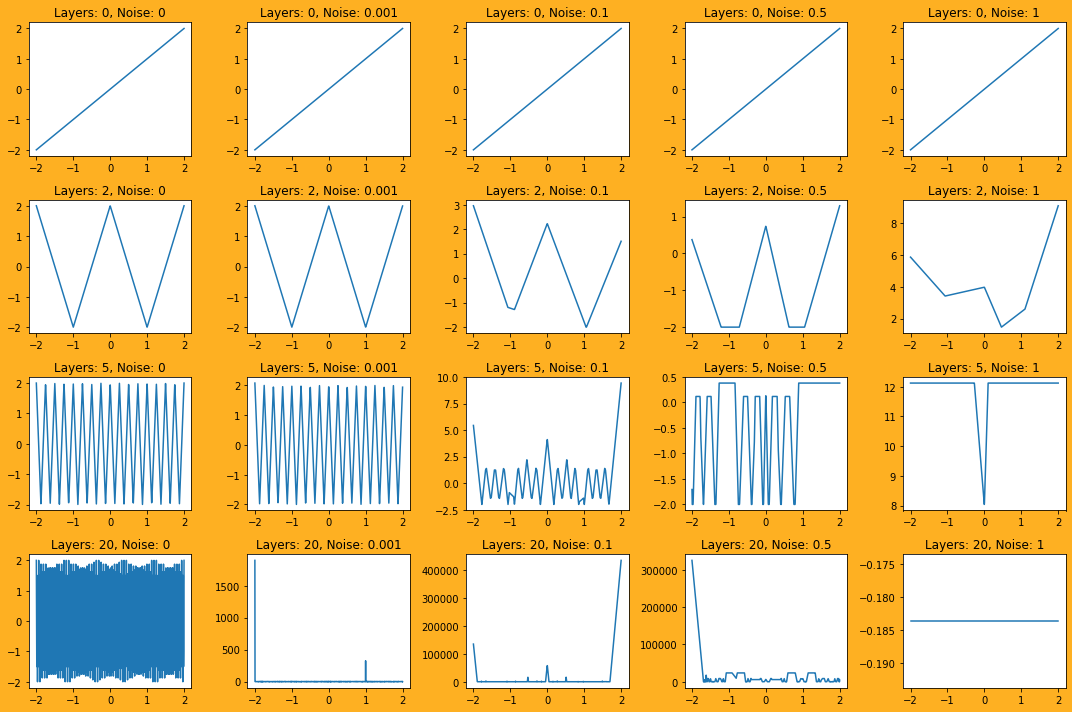

In [14]:
## Question 5 Part 1 - noisy_sawtooth_middle_layer
def noisy_sawtooth_middle_layer(noise_level = 0.1):
  layer = Linear(2, 2)
  with torch.no_grad():
    layer.weight.data = torch.Tensor([[2, 2], [-2, -2]]) + noise_level * torch.randn_like(layer.weight.data)
    layer.bias.data = torch.Tensor([-2, 2]) + noise_level * torch.randn_like(layer.bias.data)
  return layer

plot_multiple(noisy_sawtooth_middle_layer, ns=[0, 2, 5, 20], noise_levels = [0, 0.001, 0.1, 0.5, 1])

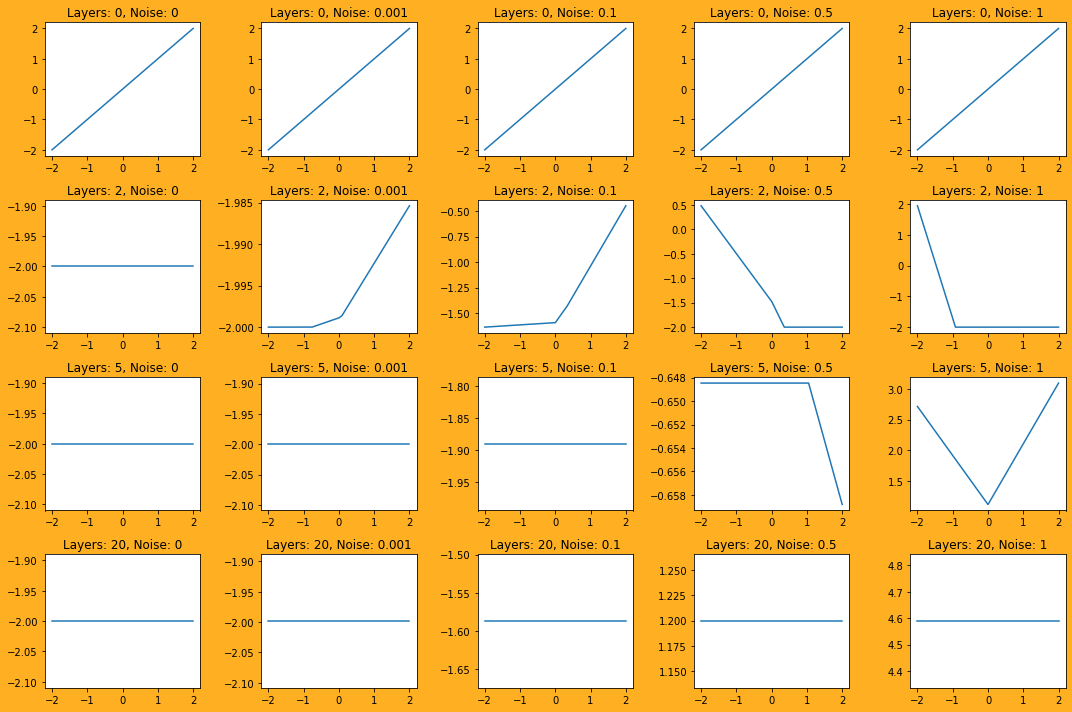

In [15]:
## Question 5 Part 2 - random_init_middle_layer
def random_init_middle_layer(noise_level = 0.1):
  layer = Linear(2, 2)
  with torch.no_grad():
    torch.nn.init.normal_(layer.weight.data, std=noise_level)
    torch.nn.init.normal_(layer.bias.data, std=noise_level)
  return layer

plot_multiple(random_init_middle_layer, ns=[0, 2, 5, 20], noise_levels = [0, 0.001, 0.1, 0.5, 1])

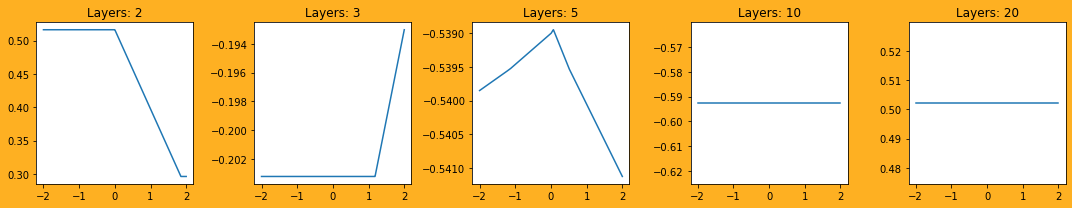

In [16]:
## Question 5 Part 3 - reset_parameters
def plot_multiple_resets(fun, ns=[]):
  fig, axes = plt.subplots(1, len(ns), figsize=(15,3))
  for i in range(len(ns)):
    n = ns[i]
    model = get_sawtooth_network(
      num_hidden_layers = n,
      middle_layer = fun
    )
    for layer_to_reset in model.children():
      try:
        layer_to_reset.reset_parameters()
      except:
        pass
    x = torch.linspace(-2,2,1000)[:, None]
    axes[i].plot(x, model(x).detach())
    axes[i].set_title("Layers: "+str(n))
  plt.tight_layout()
  fig.patch.set_facecolor('#Feb022')

plot_multiple_resets(sawtooth_middle_layer, ns=[2, 3, 5, 10, 20])

#### Answer 5 text

Sawtooth Neural Networks are interesting as they are able to represent exponentially complex systems in a simple way, by using each layer to break up current lines into two separate ones, resulting in the characteristic teeth. The number of these teeth is exponential with respect to the number of layers.

Exploring modified SNNs:

* Noisy Sawtooth Neural Networks - by adding noise to the network, we significantly decrease the number of segments in the function, and it is no longer exponential. In this case I used torch's built-in randn_like method, which returns random variables from the normal(0,1) distribution, which I convert to a normal(0, noise_level) distribution via scalar multiplication.

* Random Init Sawtooth Neural Networks - this sets the values of the weights randomly (again using a normal(0, noise_level) distribution). This also leads to a drastically decreased number of segments, which often is just 1 level line, and definitely not exponential anymore.

* Init Sawtooth Neural Networks - to understand what is happening here we have to understand the documentation behind the reset_parameters command. It turns out the default PyTorch behaviour is to set these parameters as random, similarly to the way we were doing it in the RandomInitSNN case. The difference is that the values here are set to uniform(-stdv, stdv), whereas in the RandomInitSNN I used a normal(0, noise_level) distribution.

In the two latter cases, it is very common for models with larger numbers of layers and less noise to "zero out", becoming level lines for the entire region. This is possibly caused by ReLu zeroing-out negative values, and if some layer has all zeroes, that layer will effectively kill the entire model. With more layers this is more likely to happen.

### THE END

In [17]:
print("""  ____           _   _            _   _     \n |  _"\         | \ |"|          | \ |"|    \n/| | | |       <|  \| |>        <|  \| |>   \n | |_| |\       | |\  |EURAL     | |\  |ETWORKS    \n |____/ EEP     |_| \_|          |_| \_|    \n  |||_          ||   \\,-.        ||   \\,-. \n (__)_)         (_")  (_/        (_")  (_/                 """)

  ____           _   _            _   _     
 |  _"\         | \ |"|          | \ |"|    
/| | | |       <|  \| |>        <|  \| |>   
 | |_| |\       | |\  |EURAL     | |\  |ETWORKS    
 |____/ EEP     |_| \_|          |_| \_|    
  |||_          ||   \,-.        ||   \,-. 
 (__)_)         (_")  (_/        (_")  (_/                 
